In [1]:
# minist dataset: http://yann.lecun.com/exdb/mnist/

from torchvision.datasets import MNIST
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
train = MNIST("./data/", train=True, download=True) #60000
test= MNIST("./data/",train=False, download=True) #10000

label:  3
size:  (28, 28)
max pixle value:  255


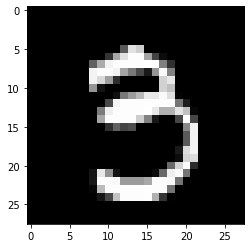

In [3]:
# show random train sample
num = np.random.randint(len(train))

plt.imshow(train[num][0], cmap='gray')
print("label: ", train[num][1])

print("size: ", train[num][0].size)

print("max pixle value: ", np.max(train[num][0]))

## Network 

In [42]:
import math

def he_norm(in_channels,out_channels, kernel_size):
    kernel_size = [kernel_size,kernel_size] if isinstance(kernel_size, int) \
                               else [int(x) for x in kernel_size]
    
    return [np.random.rand(in_channels,kernel_size[0],kernel_size[1])*np.sqrt(2/(in_channels*kernel_size[0]*kernel_size[1])) for i in range(out_channels)] 

class Conv2d():
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = [kernel_size,kernel_size] if isinstance(kernel_size, int) \
                           else [int(x) for x in kernel_size]
        self.stride = [stride,stride] if isinstance(stride, int) else [int(x) for x in stride]
        self.padding = [padding,padding] if isinstance(padding, int) else [int(x) for x in padding]
        #TODO:he_norm initialize weight
        #paper https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
        #other initialize implements
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        #https://blog.csdn.net/xxy0118/article/details/84333635
        
        #CHW
        self.kernels = he_norm(self.in_channels,self.out_channels,kernel_size)
    def __call__(self,x):
        # CHW
        in_c ,in_h, in_w= x.shape 
        out_h = math.floor( (in_h + 2*self.padding[0] - self.kernel_size[0])/self.stride[0] + 1)
        out_w = math.floor( (in_w + 2*self.padding[1] - self.kernel_size[1])/self.stride[1]+ 1)
        
#         print("output shape",out_h,out_w,len(self.kernels),out_h*out_w*len(self.kernels))
        
        values = []
        if (self.padding[0])or(self.padding[1]):
            zeroMat = np.zeros((in_c,in_h+2*self.padding[0],in_w+2*self.padding[1]))
            zeroMat[:,self.padding[0]:-self.padding[0],self.padding[1]:-self.padding[1]] = x[:,:,:]
            x = zeroMat
            print(x.shape)
            in_c ,in_h, in_w= x.shape 
        
        for kernel in self.kernels:
            for i in range(0,in_w,self.stride[1]):
                for j in range(0,in_h,self.stride[0]):
                    i_ = i+self.kernel_size[1]
                    j_ = j+self.kernel_size[0]
                    if (i_>in_w) or (j_>in_h):
                        continue
                    else:
                        #conv
                        val = (x[:,j:j_,i:i_]*kernel).sum()
#                         print(val)
                        values.append(val)
#         print(len(values))
        # CHW
        output = np.array(values).reshape(self.out_channels,out_h,out_w)
#         print(output.shape)
        return output
    
class MaxPool2d():
    def __init__(self,kernel_size,stride=None,padding=0):
        self.kernel_size = [kernel_size,kernel_size] if isinstance(kernel_size, int) \
                           else [int(x) for x in kernel_size]
        if not stride:
            self.stride=self.kernel_size
        else:
            self.stride = [stride,stride] if isinstance(stride, int) else [int(x) for x in stride]

        self.padding = [padding,padding] if isinstance(padding, int) else [int(x) for x in padding]
    def __call__(self,x):
        # CHW
        in_c ,in_h, in_w= x.shape 
        out_h = math.floor( (in_h + 2*self.padding[0] - self.kernel_size[0])/self.stride[0] + 1)
        out_w = math.floor( (in_w + 2*self.padding[1] - self.kernel_size[1])/self.stride[1]+ 1)
        
#         print("output shape",out_h,out_w,in_c,out_h*out_w*in_c)
        
        values = []
        if (self.padding[0])or(self.padding[1]):
            zeroMat = np.zeros((in_c,in_h+2*self.padding[0],in_w+2*self.padding[1]))
            zeroMat[:,self.padding[0]:-self.padding[0],self.padding[1]:-self.padding[1]] = x[:,:,:]
            x = zeroMat
#             print(x.shape)
            in_c ,in_h, in_w= x.shape 
        
        for c in range(in_c):
            for i in range(0,in_w,self.stride[1]):
                for j in range(0,in_h,self.stride[0]):
                    i_ = i+self.kernel_size[1]
                    j_ = j+self.kernel_size[0]
                    if (i_>in_w) or (j_>in_h):
                        continue
                    else:
                        #conv
                        val = x[c,j:j_,i:i_].max()
#                         print(val)
                        values.append(val)
#         print(len(values))
        # CHW
        output = np.array(values).reshape(in_c,out_h,out_w)
#         print(output.shape)
        return output
    
class Linear():
    def __init__(self,in_features, out_features):
        # TODO:Xavier initialize weight
        #CHW
        self.weights=np.random.rand(in_features,out_features)*np.sqrt(2/(in_features*out_features))
    def __call__(self,x):
        return np.matmul(x,self.weights)
        

    
def flatten(x):
    assert isinstance(x,np.ndarray),"input type must be numpy.ndarray"
    return x.reshape(1,-1)
    
    
def relu(x):
    assert isinstance(x,np.ndarray),"input type must be numpy.ndarray"
    return x.clip(0)

def softmax(x):
    #TODO
    # solving overflow and underflow https://cloud.tencent.com/developer/article/1118924
    assert isinstance(x,np.ndarray),"input type must be numpy.ndarray"
    m = x.max(axis=1)
    x = x -m
    exp_x = np.exp(x).astype(np.float64) 
    sum_exp = exp_x.sum(axis=1)
#     print(x)
#     print(exp_x)
#     print(sum_exp)
    return exp_x/sum_exp
    
    
def label2vector(label):
    vector = np.zeros(1,10)
    vector[label-1]=1
    return vector

#cross entropy: loss = -sum([y*log(y_pred) for sample in all samples])
#solving overflow and underflow by log softmax
def cross_entropy_with_log_softmax(y,output):
#https://cloud.tencent.com/developer/article/1118924
    m = output.max(axis = 1)
    output = output-m
    exp_sum = np.exp(output).sum(axis=1)
    logits = output-np.log(exp_sum)
    loss = (-y*logits).sum(axis=1)
    return loss



In [29]:
class NumpyConvNet():
    def __init__(self):
        self.conv1 = Conv2d(1,32,3,1)
        self.conv2 = Conv2d(32,64,3,1)
        self.maxpool1 = MaxPool2d(2)
        self.fc1 = Linear(9216,128)
        self.fc2 = Linear(128,10)
    def forward(self,x):
#         print(x)
        x = self.conv1(x)
#         print(x)
        x = relu(x)
#         print(x)
        x = self.conv2(x)
#         print(x)
        x = relu(x)
#         print(x)
        x = self.maxpool1(x)
#         print(x)
        x = flatten(x)
#         print(x)
        x = self.fc1(x)
#         print(x)
        x = relu(x)
#         print(x)
        x = self.fc2(x)
        
        return x

In [33]:
#test NumpyNet
net = NumpyConvNet()
dummy_input = np.random.rand(1,28,28).astype(np.float64)
dummy_input


array([[[8.55507814e-01, 5.29302760e-01, 8.32129593e-01, 8.14738994e-01,
         2.15460714e-01, 9.11847431e-01, 2.84470228e-01, 6.03863255e-01,
         5.23172052e-02, 3.22100334e-01, 7.44110559e-01, 2.14373663e-01,
         7.96267179e-02, 7.84662695e-01, 6.01889942e-01, 1.48699474e-01,
         2.49988323e-01, 2.89940234e-01, 9.88640267e-01, 4.57257405e-01,
         7.86862684e-01, 8.55632168e-01, 4.54228898e-01, 3.73201236e-01,
         6.55699768e-01, 9.43966078e-01, 5.39126691e-01, 5.79736744e-01],
        [7.86518003e-01, 6.93124590e-01, 7.00530396e-01, 4.31116090e-03,
         3.37273789e-01, 5.83134780e-01, 4.44840501e-01, 9.75742643e-02,
         2.72048798e-01, 2.59977417e-02, 5.40021265e-01, 7.02121714e-01,
         4.09869802e-01, 9.86475072e-01, 8.26293525e-01, 9.04651490e-01,
         8.05425267e-01, 5.99578291e-01, 6.88865751e-01, 7.00129078e-01,
         8.48612331e-01, 2.71838167e-01, 6.09723021e-01, 7.27328297e-01,
         9.95111955e-01, 9.63167069e-01, 4.5129972

In [38]:
res = net.forward(dummy_input)
print(res)

[[194.61907694 186.1746964  194.7753047  207.37770232 214.42547647
  224.51669068 208.99294687 196.74240552 196.13790642 198.75873104]]


In [39]:
_ = np.array([[0,1,0,0,0,0,0,0,0,0]])

In [40]:
print(_)

[[0 1 0 0 0 0 0 0 0 0]]


In [41]:
cross_entropy_with_log_softmax(_,res)

array([38.34203594])